# Download Dataset

In [33]:
#!pip install roboflow
#!pip install torch
#!pip install torchvision

In [34]:
# Import the dataset
from roboflow import Roboflow
rf = Roboflow(api_key="dnZcw1fNasJT5SaFbDdG")
project = rf.workspace("vortexbuoytrainingset").project("buoy-detection-qzjg1")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


# Dataset Overview

In [35]:
from PIL import Image
import os
from collections import Counter

def check_image_dataset(directory_path, annotation_dir, target_dimensions=None):
    """
    Checks an image dataset for validity and optional dimension requirements,
    validates the corresponding annotation files in YOLO format, and counts
    occurrences of each label to detect potential imbalance.

    Args:
        directory_path (str): Path to the dataset directory containing images.
        annotation_dir (str): Path to the directory containing YOLO annotation files.
        target_dimensions (tuple): Optional. A tuple (width, height) to validate image dimensions.

    Returns:
        None
    """
    valid_images = 0
    invalid_images = 0
    label_count = 0
    missing_labels = 0
    label_frequencies = Counter()

    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tif')):
                file_path = os.path.join(root, file)
                label_path = os.path.join(annotation_dir, os.path.splitext(file)[0] + '.txt')

                try:
                    # Open and validate image
                    with Image.open(file_path) as img:
                        if target_dimensions and img.size != target_dimensions:
                            print(f"   WARNING: Image dimensions {img.size} do not match target {target_dimensions}.")
                        img.verify()
                        valid_images += 1

                    # Validate label file
                    if os.path.exists(label_path):
                        with open(label_path, 'r') as label_file:
                            lines = label_file.readlines()
                            label_count += len(lines)

                            # Parse labels and update frequency count
                            for i, line in enumerate(lines):
                                parts = line.strip().split()
                                if len(parts) != 5:
                                    print(f"   ERROR: Invalid YOLO format in {label_path} on line {i + 1}: {line}")
                                else:
                                    label_class = parts[0]
                                    label_frequencies[label_class] += 1
                    else:
                        print(f"   WARNING: Missing label file for {file_path}")
                        missing_labels += 1

                except (IOError, SyntaxError) as e:
                    print(f"ERROR: {file_path} is invalid or corrupted. Error: {e}")
                    invalid_images += 1

    print("\nDataset Check Complete!")
    print(f" - Total valid images: {valid_images}")
    print(f" - Total invalid/corrupt images: {invalid_images}")
    print(f" - Total labels processed: {label_count}")
    print(f" - Missing label files: {missing_labels}")

    print("\nLabel Frequencies:")
    for label, count in label_frequencies.items():
        print(f" - Label {label}: {count} occurrences ({round(count/len(label_frequencies))}%)")

In [36]:
# Dataset image size 640x640
original_image_size = 640

# Train dataset
images_train_dir = "Buoy-Detection-1/train/images"
annotations_train_dir = "Buoy-Detection-1/train/labels"
check_image_dataset(images_train_dir, annotations_train_dir, target_dimensions=(original_image_size, original_image_size))


Dataset Check Complete!
 - Total valid images: 521
 - Total invalid/corrupt images: 0
 - Total labels processed: 521
 - Missing label files: 0

Label Frequencies:
 - Label 2: 130 occurrences (32%)
 - Label 0: 148 occurrences (37%)
 - Label 3: 132 occurrences (33%)
 - Label 1: 111 occurrences (28%)


In [37]:
# Test dataset
images_test_dir = "Buoy-Detection-1/test/images"
annotations_test_dir = "Buoy-Detection-1/test/labels"
check_image_dataset(images_test_dir, annotations_test_dir, target_dimensions=(original_image_size, original_image_size))


Dataset Check Complete!
 - Total valid images: 75
 - Total invalid/corrupt images: 0
 - Total labels processed: 75
 - Missing label files: 0

Label Frequencies:
 - Label 0: 21 occurrences (5%)
 - Label 3: 19 occurrences (5%)
 - Label 2: 19 occurrences (5%)
 - Label 1: 16 occurrences (4%)


In [38]:
# Validation dataset
images_valid_dir = "Buoy-Detection-1/valid/images"
annotations_valid_dir = "Buoy-Detection-1/valid/labels"
check_image_dataset(images_valid_dir, annotations_valid_dir, target_dimensions=(original_image_size, original_image_size))


Dataset Check Complete!
 - Total valid images: 148
 - Total invalid/corrupt images: 0
 - Total labels processed: 148
 - Missing label files: 0

Label Frequencies:
 - Label 0: 42 occurrences (10%)
 - Label 2: 37 occurrences (9%)
 - Label 1: 32 occurrences (8%)
 - Label 3: 37 occurrences (9%)


## Ploting some samples

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_sample_with_bboxes(image_dir, label_dir, class_names, num_samples=5):
    """
    Plots samples from the dataset with bounding boxes and class labels.

    Args:
        image_dir (str): Path to the directory containing images.
        label_dir (str): Path to the directory containing YOLO annotations (labels).
        class_names (list): List of class names corresponding to class IDs.
        num_samples (int): Number of samples to plot.

    Returns:
        None
    """
    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if len(image_files) == 0:
        print("No images found in the specified directory.")
        return

    # Sample a few images
    sampled_images = image_files[:num_samples] if num_samples < len(image_files) else image_files

    for image_file in sampled_images:
        # File paths
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')

        # Load image
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 1, figsize=(7, 7))
            ax.imshow(img)
            ax.set_title(f"Image: {image_file}")

            # If label file exists, draw bounding boxes
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) != 5:
                            print(f"Invalid label format in {label_path}. Skipping line: {line}")
                            continue
                        
                        # Parse YOLO annotation
                        class_id, x_center, y_center, width, height = map(float, parts)
                        class_name = class_names[int(class_id)] if int(class_id) < len(class_names) else f"Class {int(class_id)}"
                        
                        # Convert normalized YOLO bbox to pixel coordinates
                        img_width, img_height = img.size
                        x_center *= img_width
                        y_center *= img_height
                        width *= img_width
                        height *= img_height
                        
                        # Top-left corner
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        
                        # Draw rectangle
                        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='green', facecolor='none')
                        ax.add_patch(rect)
                        ax.text(x_min, y_min - 5, class_name, color='green', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

            plt.show()

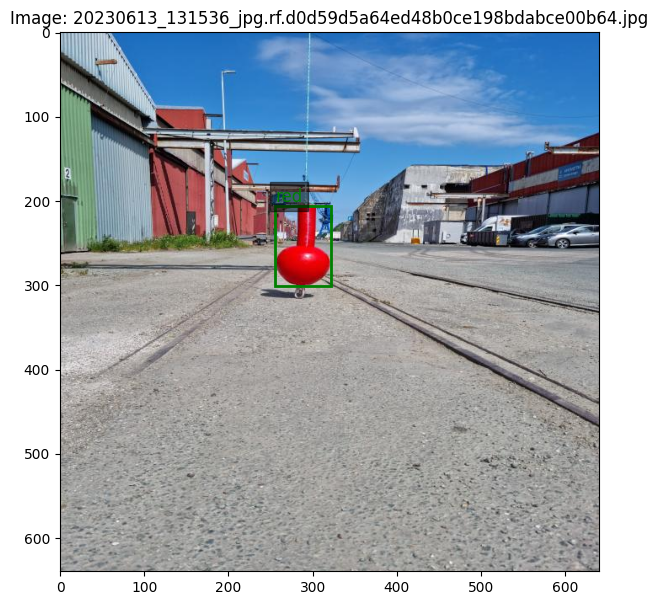

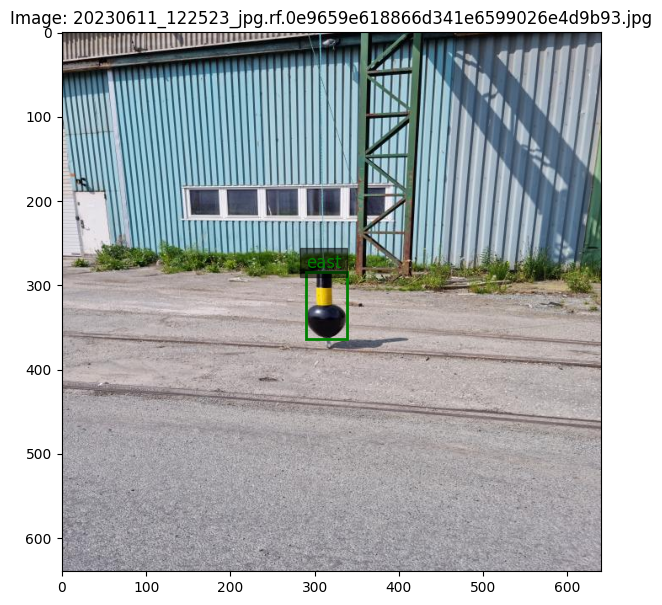

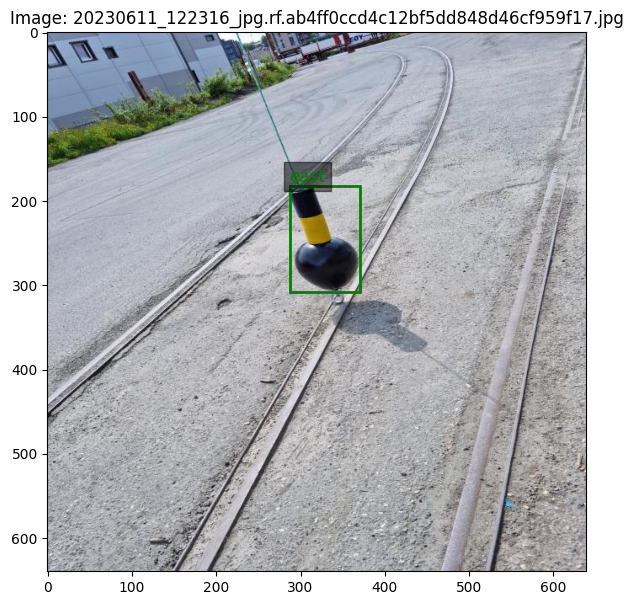

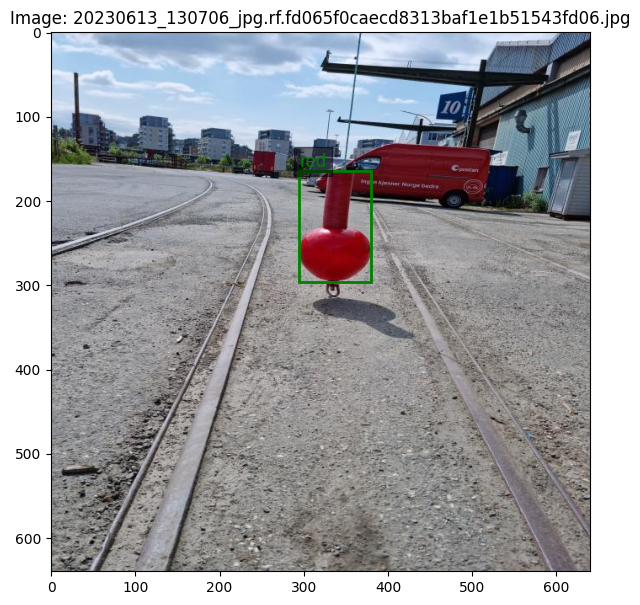

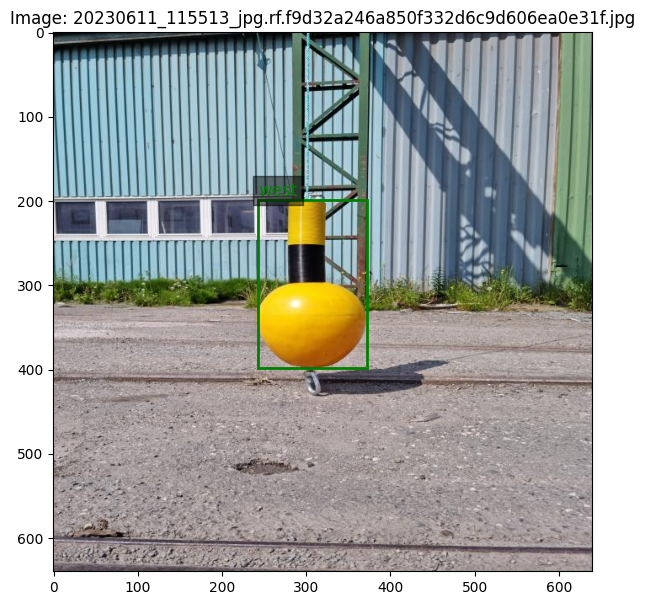

In [40]:
# Pass class names by index
class_names = ["east", "green", "red", "west"]  
plot_sample_with_bboxes(images_train_dir, annotations_train_dir, class_names, num_samples=5)

# Prepare Dataset

In [41]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class BuoyDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, image_size, transform=None, original_image_size = 640):
        """
        Args:
            images_dir (str): Path to the folder containing buoy images.
            annotations_dir (str): Path to the folder containing YOLO-style annotations.
            image_size (int): Target size for resizing images (image_size x image_size).
            transform (callable, optional): Transformations for images.
        """
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.image_size = image_size
        self.transform = transform

        # List all image files
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image and corresponding annotation file
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        annotation_path = os.path.join(self.annotations_dir, os.path.splitext(img_file)[0] + '.txt')

        # Load image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Load and parse annotation
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        bboxes = []
        labels = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert normalized YOLO coordinates to pixel coordinates
            x_min = (x_center - width / 2) 
            y_min = (y_center - height / 2) 
            x_max = (x_center + width / 2) 
            y_max = (y_center + height / 2)

            bboxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_id)

        # Convert to tensors
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        return image, labels, bboxes

## Augmentations 

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

img_resize = 128
# Define transforms
transform = Compose([
    Resize((img_resize, img_resize)),  # Resize images to a fixed size
    ToTensor(),          # Convert to PyTorch tensor
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Train dataset
train_dataset = BuoyDataset(images_train_dir, annotations_train_dir, image_size=img_resize, transform=transform, original_image_size = original_image_size)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# Test dataset
test_dataset = BuoyDataset(images_test_dir, annotations_test_dir, image_size=img_resize, transform=transform, original_image_size = original_image_size)
test_datalaoder = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Valdiation dataset
valid_dataset = BuoyDataset(images_valid_dir, annotations_valid_dir, image_size=img_resize, transform=transform, original_image_size = original_image_size)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [43]:
# Check dataset length
print(train_dataset.__len__())
print(test_dataset.__len__())
print(valid_dataset.__len__())

521
75
148


In [44]:
# Check dataset image
idx = 0
print(train_dataset.__getitem__(idx)[0])
print(train_dataset.__getitem__(idx)[0].shape)

tensor([[[ 0.2392,  0.2157,  0.2392,  ..., -0.7412, -0.7490, -0.7490],
         [ 0.2392,  0.2314,  0.2314,  ..., -0.7412, -0.7490, -0.7490],
         [ 0.2157,  0.2235,  0.2392,  ..., -0.7412, -0.7412, -0.7412],
         ...,
         [ 0.2392,  0.1922,  0.1765,  ...,  0.2157,  0.1294,  0.1529],
         [ 0.2471,  0.2078,  0.2235,  ...,  0.0980,  0.1529,  0.2784],
         [ 0.0902,  0.2392,  0.2941,  ..., -0.0431,  0.0118,  0.1137]],

        [[ 0.4196,  0.3961,  0.4196,  ..., -0.1373, -0.1451, -0.1451],
         [ 0.4196,  0.4118,  0.4118,  ..., -0.1373, -0.1451, -0.1451],
         [ 0.4039,  0.4118,  0.4196,  ..., -0.1373, -0.1373, -0.1373],
         ...,
         [ 0.2549,  0.2078,  0.1922,  ...,  0.2157,  0.1294,  0.1529],
         [ 0.2627,  0.2235,  0.2314,  ...,  0.0980,  0.1529,  0.2784],
         [ 0.1059,  0.2549,  0.3020,  ..., -0.0431,  0.0118,  0.1137]],

        [[ 0.5451,  0.5216,  0.5451,  ...,  0.5059,  0.4980,  0.4980],
         [ 0.5451,  0.5373,  0.5373,  ...,  0

In [45]:
# Check dataset label
idx = 0
print(train_dataset.__getitem__(idx)[1])

tensor([2])


In [46]:
# Check dataset normalized Bounding Box
idx = 0
print(train_dataset.__getitem__(idx)[2])

tensor([[0.3996, 0.3215, 0.5035, 0.4707]])


## Model


In [47]:
import torch.nn as nn
import torch

class BuoyDetector(nn.Module):
    def __init__(self, num_classes=4, input_size=128):
        super(BuoyDetector, self).__init__()
        self.input_size = input_size
        
        # Shared feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces size by a factor of 2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces size by a factor of 2
        )

        # Calculate the size of the flattened feature map
        # Input size is halved by each MaxPool2d layer
        conv_output_size = input_size // (2 * 2)  # 2 MaxPool2d layers
        flattened_size = conv_output_size * conv_output_size * 32

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Output logits for classes
        )

        # Bounding box regression head
        self.regressor = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # Output bounding box [x_min, y_min, x_max, y_max]
        )

    def forward(self, x):
        # Extract shared features
        features = self.features(x)
        # Flatten the feature map
        flattened = torch.flatten(features, start_dim=1)
        # Classification head
        class_logits = self.classifier(flattened)
        # Bounding box regression head
        bbox_coordinates = self.regressor(flattened)        
        return class_logits, bbox_coordinates

In [48]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [49]:
model = BuoyDetector(num_classes=4, input_size=img_resize).to(device)

## Train

### Loss Functions

In [50]:
# Loss functions
classification_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.MSELoss()

### Optimizer

In [51]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
for batch in train_dataloader:
    images, labels, bboxes = batch
    print(f"Images Shape: {images.shape}")
    print(f"Labels Shape: {labels.shape}")
    print(f"Bounding Boxes Shape: {bboxes.shape}")
    break

Images Shape: torch.Size([8, 3, 128, 128])
Labels Shape: torch.Size([8, 1])
Bounding Boxes Shape: torch.Size([8, 1, 4])


In [53]:
def train(model, dataloader, optimizer, classification_loss_fn, bbox_loss_fn, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_class_loss = 0.0
        epoch_bbox_loss = 0.0
        epoch_total_loss = 0.0 

        for images, labels, bboxes in dataloader:
            # Move data to the specified device
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)

            # Ensure shapes align
            labels = labels.squeeze()  # [batch_size]
            bboxes = bboxes.view(-1, 4)  # [batch_size, 4]

            # Compute losses
            if labels.dim() == 0:  # Ensure labels have a batch dimension
                labels = labels.unsqueeze(0)

            # Debugging shapes
            #print(f"Images Shape: {images.shape}")
            #print(f"Class Logits Shape: {model(images)[0].shape}")  # Classification logits
            #print(f"Labels Shape: {labels.shape}")
            #print(f"BBox Predictions Shape: {model(images)[1].shape}")  # Bounding box predictions

            # Forward pass
            class_logits, bbox_predictions = model(images)

            # Compute losses
            try:
                class_loss = classification_loss_fn(class_logits, labels)
            except Exception as e:
                print(f"Error in Classification Loss: {e}")
                print(f"Class Logits: {class_logits}")
                print(f"Labels: {labels}")
                raise

            bbox_loss = bbox_loss_fn(bbox_predictions, bboxes)
            total_loss = class_loss + bbox_loss

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Accumulate losses for epoch tracking
            epoch_class_loss += class_loss.item()
            epoch_bbox_loss += bbox_loss.item()
            epoch_total_loss += total_loss.item()

        # Print epoch results
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Classification Loss: {epoch_class_loss:.4f}, "
              f"BBox Loss: {epoch_bbox_loss:.4f}, "
              f"Total Loss: {epoch_total_loss:.4f}")

In [54]:
train(model, train_dataloader, optimizer, classification_loss_fn, bbox_loss_fn, device, 100)

Epoch [1/100], Classification Loss: 77.6005, BBox Loss: 4.8388, Total Loss: 82.4393
Epoch [2/100], Classification Loss: 22.6999, BBox Loss: 0.7136, Total Loss: 23.4135
Epoch [3/100], Classification Loss: 4.7643, BBox Loss: 0.4901, Total Loss: 5.2544
Epoch [4/100], Classification Loss: 1.0907, BBox Loss: 0.3606, Total Loss: 1.4513
Epoch [5/100], Classification Loss: 0.2986, BBox Loss: 0.2461, Total Loss: 0.5447
Epoch [6/100], Classification Loss: 0.1060, BBox Loss: 0.1832, Total Loss: 0.2892
Epoch [7/100], Classification Loss: 0.0721, BBox Loss: 0.0958, Total Loss: 0.1679
Epoch [8/100], Classification Loss: 0.0508, BBox Loss: 0.0703, Total Loss: 0.1211
Epoch [9/100], Classification Loss: 0.0387, BBox Loss: 0.0559, Total Loss: 0.0946
Epoch [10/100], Classification Loss: 0.0335, BBox Loss: 0.0453, Total Loss: 0.0788
Epoch [11/100], Classification Loss: 0.0249, BBox Loss: 0.0331, Total Loss: 0.0580
Epoch [12/100], Classification Loss: 0.0202, BBox Loss: 0.0277, Total Loss: 0.0479
Epoch [13

## Evaluation

In [55]:
def evaluate(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels, bboxes in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            # Get predictions
            class_logits, bbox_predictions = model(images)
            predicted_classes = torch.argmax(class_logits, dim=1)

            # Compute accuracy
            correct_predictions += (predicted_classes == labels).sum().item()
            total_predictions += labels.size(0)

            # Debugging output
            print("Predicted classes:", predicted_classes)
            print("True classes:", labels)
            print("Predicted bounding boxes:", bbox_predictions)

    accuracy = correct_predictions / total_predictions * 100
    print(f"Classification Accuracy: {accuracy:.2f}%")
    return accuracy

In [56]:
evaluate(model=model, dataloader=test_datalaoder, device=device)

Predicted classes: tensor([0, 3, 2, 1, 2, 0, 0, 1], device='cuda:0')
True classes: tensor([[0],
        [3],
        [2],
        [1],
        [2],
        [0],
        [0],
        [1]], device='cuda:0')
Predicted bounding boxes: tensor([[0.3788, 0.2935, 0.6188, 0.6940],
        [0.4592, 0.4033, 0.5481, 0.5616],
        [0.3694, 0.1686, 0.6343, 0.5534],
        [0.4525, 0.2990, 0.5909, 0.5359],
        [0.4385, 0.3445, 0.5775, 0.5500],
        [0.4228, 0.4335, 0.5134, 0.6083],
        [0.4695, 0.3968, 0.5493, 0.5440],
        [0.4181, 0.2937, 0.6154, 0.6911]], device='cuda:0')
Predicted classes: tensor([3, 0, 1, 2, 2, 0, 1, 2], device='cuda:0')
True classes: tensor([[3],
        [2],
        [1],
        [2],
        [2],
        [0],
        [1],
        [2]], device='cuda:0')
Predicted bounding boxes: tensor([[0.3971, 0.3275, 0.5832, 0.6326],
        [0.4913, 0.4693, 0.5774, 0.6274],
        [0.4259, 0.3407, 0.4998, 0.4973],
        [0.4717, 0.3164, 0.5585, 0.4552],
        [0.3027,

246.66666666666669

In [57]:
import torch.nn.functional as F

def predict_classes(model, dataloader, device, class_names=None):
    """
    Predict and display classes for a batch of images.

    Args:
        model (torch.nn.Module): Trained classification model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run predictions on.
        class_names (list): Optional. List of class names corresponding to the output indices.

    Returns:
        None
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels, bboxes in dataloader:
            # Move data to the device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            class_logits, bbox_predictions = model(images)

            # Compute predictions
            class_probs = F.softmax(class_logits, dim=1)  # Convert logits to probabilities
            predicted_classes = torch.argmax(class_probs, dim=1)  # Get the class indices

            # Display predictions
            for i, pred in enumerate(predicted_classes):
                class_name = class_names[pred.item()] if class_names else pred.item()
                print(f"Image {i + 1}: Predicted Class: {class_name}, True Class: {labels[i].item()}")

            break  # Only process one batch for display

In [58]:
# Assuming 4 classes with names
class_names = ["east", "green", "red", "west"]  

predict_classes(model, train_dataloader, device, class_names)

Image 1: Predicted Class: green, True Class: 1
Image 2: Predicted Class: east, True Class: 0
Image 3: Predicted Class: red, True Class: 2
Image 4: Predicted Class: east, True Class: 0
Image 5: Predicted Class: west, True Class: 3
Image 6: Predicted Class: green, True Class: 1
Image 7: Predicted Class: west, True Class: 3
Image 8: Predicted Class: red, True Class: 2
